# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt


import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

d:\miniconda3\envs\py38\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Setting up network and loading weights

In [2]:
model_name = "mono_1024x320"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

d:\miniconda3\envs\py38\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
d:\miniconda3\envs\py38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Loading the test image and preprocessing

In [3]:
image_path = r"C:\Users\wac\Desktop\fx\new\img\000204_22.28215907_114.12499665_202307_8_102.jpg"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

## Prediction using the PyTorch model

In [4]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

## Plotting

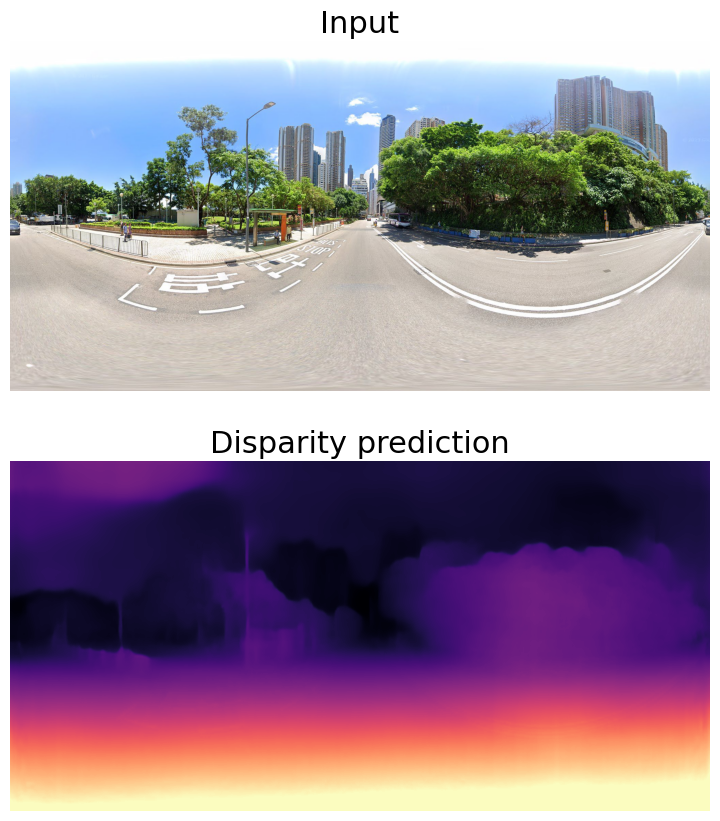

In [8]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

# 更改路径为你想要保存的文件夹路径
save_path = r"D:\paper1\3-实验作图\3-第三版作图\图3\monodepth2\\"

# 更改文件名为你想要的文件名，也可以在这里包含文件格式（如.png）
file_name = "000204_disparity_prediction.png"

# 将图像保存到指定路径
plt.savefig(save_path + file_name)

# 展示图像（可选）
plt.show()

单独保存深度估计图

In [12]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# 假设这里有合适的disp和original_height、original_width等数据（原代码中应该已定义）
disp_resized = torch.nn.functional.interpolate(disp,
                                                (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

# 创建新的figure，设置dpi为300，用于单独保存Disparity图（去掉了原subplot(211)展示input_image的部分）
plt.figure(figsize=(10, 10), dpi=300)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.axis('off')
plt.tight_layout()

# 更改路径为你想要保存的文件夹路径，注意路径需存在，否则保存会出错
save_path = r"D:\paper1\3-实验作图\3-第三版作图\图3\monodepth2\\"
# 更改文件名为期望的文件名，后缀改为.tif格式，且体现300dpi相关信息方便识别
file_name = "000204_disparity_prediction_300dpi.tif"

# 将图像保存到指定路径，添加dpi=300参数明确分辨率，使用bbox_inches='tight'确保紧凑保存（和tight_layout配合）
plt.savefig(save_path + file_name, dpi=300, bbox_inches='tight')

# 关闭当前figure，避免影响后续可能的绘图操作
plt.close()

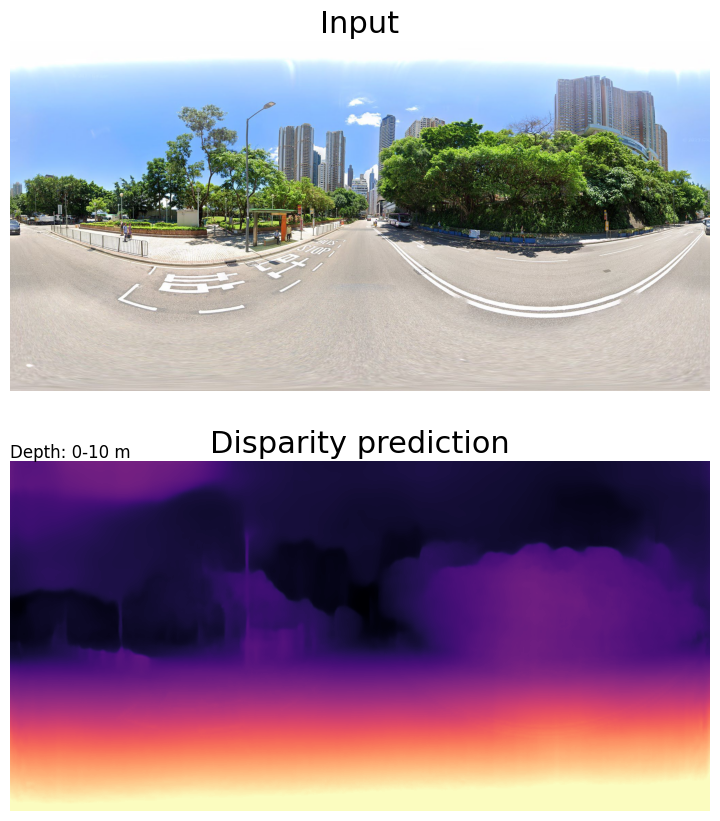

In [21]:
# 存储深度图像的视差值
disp_values = disp_resized.squeeze().cpu().numpy()

# 选择要转换的像素点坐标（假设这里选择像素点(200, 300)）
x = 250
y = 636
# 获取像素点处的视差值
disparity_value = disp_values[y, x]
print(disparity_value)
# 定义相机的基线长度（像素）和焦距（米）
baseline = 721  # 基线长度（像素）
focal_length = 0.54  # 焦距（米）
w1 = 10000
c = 1.5

# 将视差值转换为深度值（米）
depth = (baseline * focal_length) / disparity_value
depth2 = ((baseline * focal_length) / (w1*disparity_value))*c

# 打印深度值（米）
print(f"Depth at pixel ({x}, {y}): {depth} meters")

def calculate_baseline_and_focal_length(disparity_value, depth, focal_length_guess=0.54):
    """
    计算二元一次方程组 depth = (baseline * focal_length) / disparity_value 中的 baseline 和 focal_length。

    参数:
    disparity_value (float): 视差值。
    depth (float): 深度值（米）。
    focal_length_guess (float): 初始猜测的焦距值（米）。

    返回:
    tuple: 包含 baseline 和 focal_length 两个值的元组。
    """
    # 初始猜测的 baseline 和 focal_length 值
    baseline_guess = 1.0  # 初始猜测的基线长度
    focal_length = focal_length_guess

    # 迭代求解 baseline
    max_iterations = 1000  # 最大迭代次数
    tolerance = 1e-6  # 允许的误差范围

    for i in range(max_iterations):
        # 计算当前深度值对应的视差值
        estimated_disparity = (baseline_guess * focal_length) / depth

        # 计算误差
        error = disparity_value - estimated_disparity

        # 如果误差足够小，停止迭代
        if abs(error) < tolerance:
            break

        # 根据误差调整 baseline
        baseline_guess += error * 0.01  # 调整步长

    return baseline_guess, focal_length
disparity_value2 = 0.24178019  # 视差值
depth = 4  # 深度值（米）
focal_length_guess = 0.54  # 初始焦距猜测值（米）

baseline, focal_length = calculate_baseline_and_focal_length(disparity_value2, depth, focal_length_guess)
print(f"Estimated Baseline: {baseline} meters")
print(f"Estimated Focal Length: {focal_length} meters")
depth = (baseline * focal_length) / disparity_value
print(f"Depth at pixel ({x}, {y}): {depth} meters")



0.15122168
Depth at pixel (250, 636): 2574.6308731804247 meters
Estimated Baseline: 1.5861014955479873 meters
Estimated Focal Length: 0.54 meters
Depth at pixel (250, 636): 5.663836169813442 meters
